In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [2]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz

--2023-11-04 04:12:48--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Industrial_and_Scientific.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210409178 (201M) [application/x-gzip]
Saving to: ‘Industrial_and_Scientific.json.gz’

Industrial_and_Scie 100%[===================>] 200.66M  50.1MB/s    in 4.4s    

2023-11-04 04:12:52 (45.1 MB/s) - ‘Industrial_and_Scientific.json.gz’ saved [210409178/210409178]



In [3]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz

--2023-11-04 04:12:53--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Industrial_and_Scientific.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83600786 (80M) [application/x-gzip]
Saving to: ‘meta_Industrial_and_Scientific.json.gz’

meta_Industrial_and 100%[===================>]  79.73M  40.8MB/s    in 2.0s    

2023-11-04 04:12:55 (40.8 MB/s) - ‘meta_Industrial_and_Scientific.json.gz’ saved [83600786/83600786]



In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=d6103c129a40a617e155edf667c9ced6bb0a0ed1386f57c38d8b523169a385f8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Data Reading

In [5]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("readGZ") \
    .master("local[*]") \
    .config("spark.default.parallelism", 2) \
    .config("spark.sql.shuffle.partitions", 2) \
    .getOrCreate()

# Read the gzipped JSON file directly into a DataFrame
df = spark.read.json("Industrial_and_Scientific.json.gz")

In [6]:
# Show the DataFrame to check if it's loaded correctly
df.show(10)

+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+-----+--------------------+--------------+--------+----+
|0176496920| NULL|    5.0|Arrived on time, ...|01 23, 2013|A3FANY5GOT5X0W|    Kelly Keyser| NULL|  Just as described!|    1358899200|    true|NULL|
|0176496920| NULL|    5.0|This device was h...| 11 5, 2012| AT6HRPPYOPHMB|       Michael C| NULL|        Great device|    1352073600|    true|NULL|
|0176496920| NULL|    4.0|Just a clicker no...|10 17, 2012| A4IX7B38LIN1E|              BH| NULL|         Pretty Good|    1350432000|    true|NULL|
|0176496920| NULL|    5.0|Great response ca...|03 29, 2017|A12Q4LR8N17AOZ|   Waterfall3500| NULL|Thank you for t

In [7]:
### load the meta data

df_meta = spark.read.json("meta_Industrial_and_Scientific.json.gz")

In [8]:
df_meta.show(10)

+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|            category|             date|         description|details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat| price|                rank|similar_item|               tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------------------+-----------------+--------------------+-------+--------------------+---+--------------------+--------------------+--------------------+------+--------------------+------------+--------------------+-----+--------------------+
|[1454894547, 0133...|               

## Discussion



1.   We can not read some categories (especially those with large data, in this case, the sofrware category) directly in Spark; Need to figure out why and how to solve this. (Tried reading by in raw and use pandas and then spark, but this also failed.)
(I skipped this question by choosing another category which is fine to read directly)





# Data Pre-Processing and visulization

In [9]:
# Drop the image column because I don't think we need it
df = df.drop('image')

In [10]:
from pyspark.sql.functions import col, when, length, unix_timestamp, to_date

# Handling missing values: For simplicity, we'll drop rows with any NULLs
df = df.na.drop()

# Filtering out unverified reviews
df = df.filter(col('verified') == True)

# Feature Engineering - creating a new feature for the length of the reviewText
df = df.withColumn('reviewText_length', length(col('reviewText')))


In [11]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{NULL, NULL, NULL...|Great studying ma...|    1407024000|    true|   6|              390|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{NULL, NULL, NULL...|             Creased|    1402272000|    true|   4|              157|
|1587790637|    1.0|Very poor packagi...| 04 8, 2014|A39NP41GNG6DJT|  Nicole Ryan|{NULL, NULL, NULL...|Poster bent and w...|    1396915200| 

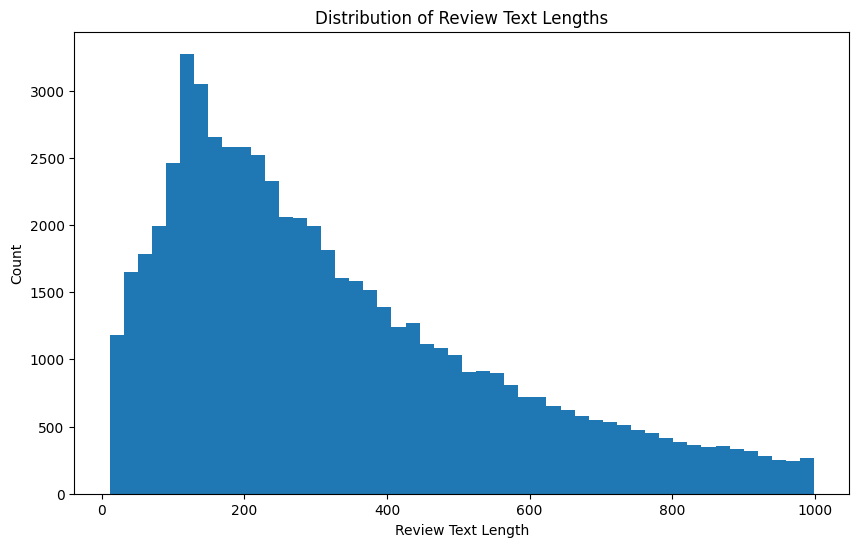

In [27]:
review_lengths = df.select('reviewText_length').rdd.flatMap(lambda x: x).collect()

# Now convert this list to a Pandas Series
pd_series = pd.Series(review_lengths)

# Plotting the distribution of reviewText_length using Pandas/Matplotlib
plt.figure(figsize=(10, 6))
pd_series.hist(bins=50)  # Adjust the number of bins for your specific dataset
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Review Text Length')
plt.ylabel('Count')
plt.grid(False)
plt.show()

In [12]:
# Example of filtering based on a condition, such as reviews that are too short/long might be outliers
df = df.filter(col('reviewText_length') > 10)  # Example threshold

df = df.filter(col('reviewText_length') < 1000)  # Example threshold

In [13]:
# Text Processing - cleaning the review text, tokenizing, and removing stop words (simplified example)
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol='reviewText', outputCol='reviewText_tokens')
df = tokenizer.transform(df)
remover = StopWordsRemover(inputCol='reviewText_tokens', outputCol='reviewText_clean')
df = remover.transform(df)

In [14]:
# Show the processed DataFrame
df.show(10)

+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|      asin|overall|          reviewText| reviewTime|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|
+----------+-------+--------------------+-----------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+
|1587790637|    5.0|I love everything...| 08 3, 2014| ALORN8T3UJC88| Ji Sung Moon|{NULL, NULL, NULL...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...|
|1587790637|    2.0|Disappointed with...| 06 9, 2014|A2DR04A9BINUE6|        Becky|{NULL, NULL, NULL...|             Creased|    1402272000|    t

In [15]:
from pyspark.sql.functions import when, col, length, split

# Split reviewTime into day, month, and year
split_col = split(df['reviewTime'], ' ')
df = df.withColumn('Day', split_col.getItem(0))
df = df.withColumn('Month', split_col.getItem(1).substr(0,2))
df = df.withColumn('Year', split_col.getItem(2))
df = df.drop('reviewTime')

# Convert 'vote' to integer type
df = df.withColumn('vote', df['vote'].cast('int'))

In [16]:
df.show(10)

+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|      asin|overall|          reviewText|    reviewerID| reviewerName|               style|             summary|unixReviewTime|verified|vote|reviewText_length|   reviewText_tokens|    reviewText_clean|Day|Month|Year|
+----------+-------+--------------------+--------------+-------------+--------------------+--------------------+--------------+--------+----+-----------------+--------------------+--------------------+---+-----+----+
|1587790637|    5.0|I love everything...| ALORN8T3UJC88| Ji Sung Moon|{NULL, NULL, NULL...|Great studying ma...|    1407024000|    true|   6|              390|[i, love, everyth...|[love, everything...| 08|   3,|2014|
|1587790637|    2.0|Disappointed with...|A2DR04A9BINUE6|        Becky|{NULL, NULL, NULL...|             Creased|    1402272000|    t

In [37]:
df.select('reviewerName').distinct().count()

44622

In [38]:
df.select('asin').distinct().count()

7425

In [18]:
from pyspark.sql.functions import avg, count

# Average rating
average_rating = df.agg(avg("overall")).first()[0]

# Count of reviews for each asin
reviews_per_asin = df.groupBy("asin").agg(count("reviewerID").alias("Number_of_Reviews"))

# Summary for vote column
votes_summary = df.describe(['vote'])



In [25]:
# Count of reviews for each reviewer
reviews_per_reviewers = df.groupBy("reviewerID").agg(count("asin").alias("Number_of_Reviews"))

In [22]:
votes_summary

+-------+------------------+
|summary|              vote|
+-------+------------------+
|  count|             60675|
|   mean| 5.742991347342398|
| stddev|14.510501013597002|
|    min|                 2|
|    max|               984|
+-------+------------------+



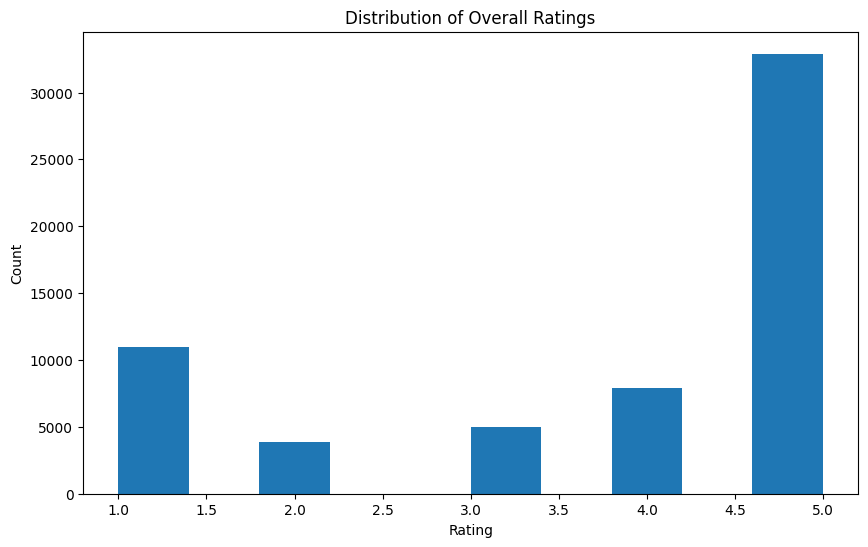

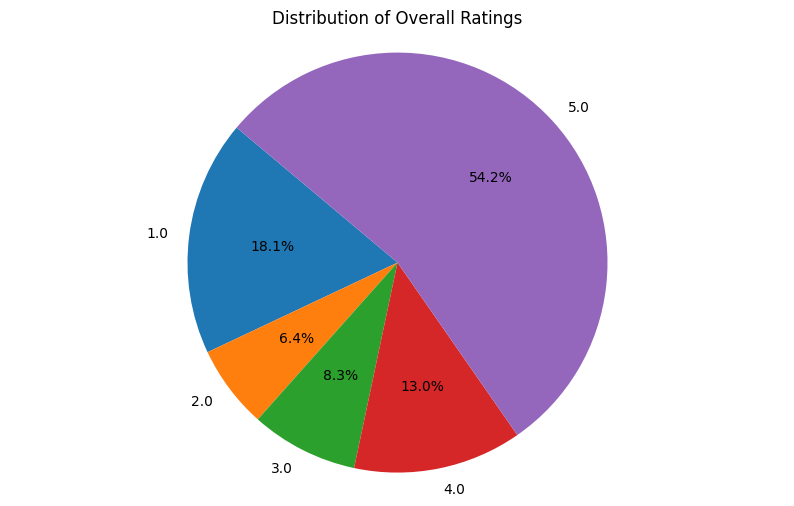

KeyError: ignored

<Figure size 1000x600 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for Visualization
pdf = df.toPandas()
reviews_per_asin_pdf = reviews_per_asin.toPandas()

# Histogram for overall ratings
plt.figure(figsize=(10, 6))
pdf['overall'].hist()
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# Plotting the pie chart for overall ratings
rating_counts = pdf['overall'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Overall Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()




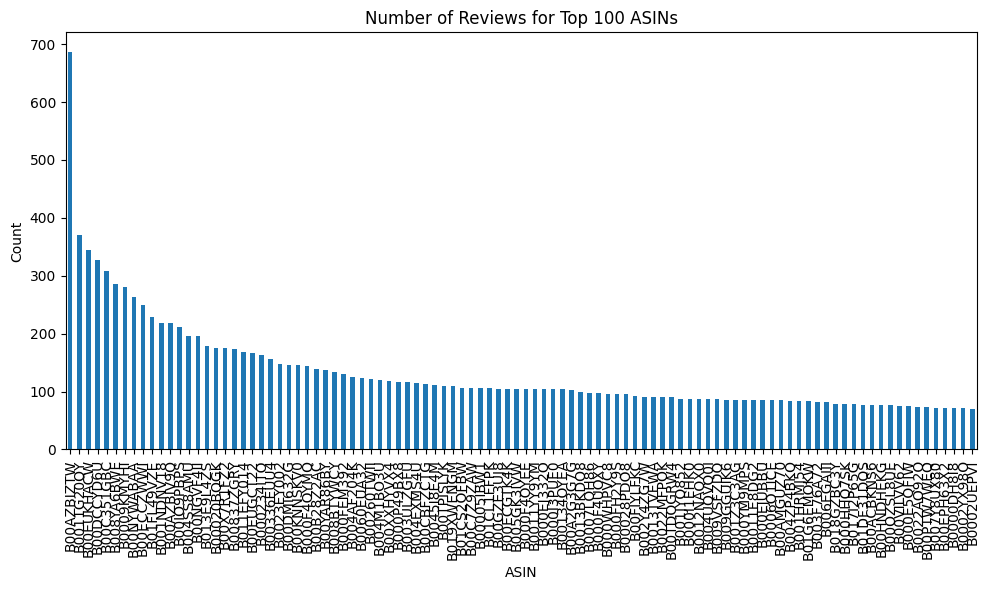

In [24]:

# Bar chart for number of reviews for each asin
top_reviews_per_asin_pdf = reviews_per_asin_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'asin' as the index and plot the 'review_count' column
top_reviews_per_asin_pdf.set_index('asin')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 ASINs')
plt.ylabel('Count')
plt.xlabel('ASIN')
plt.grid(False)
plt.tight_layout()
plt.show()

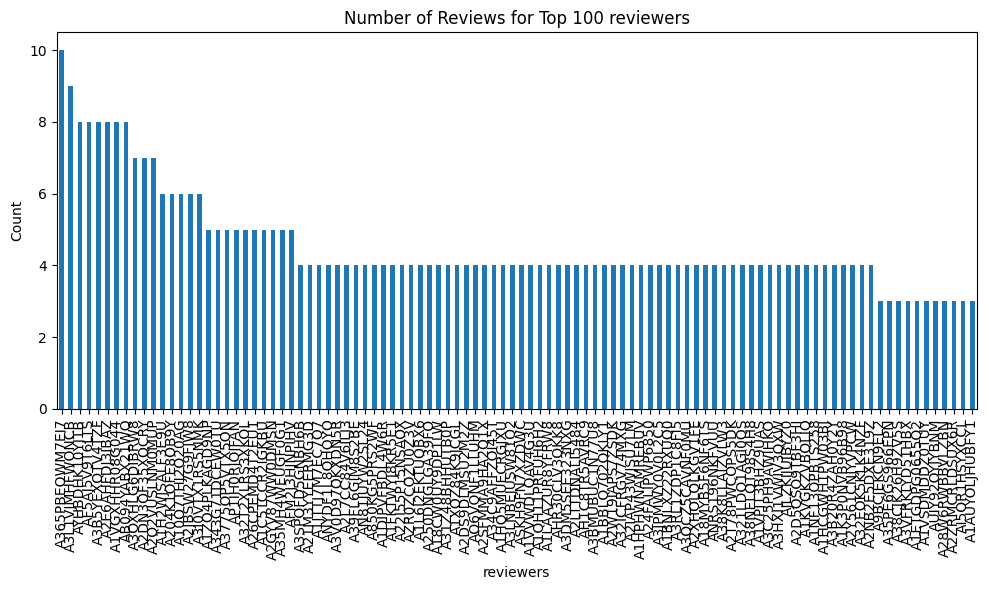

In [26]:
# Bar chart for number of reviews for each reviewers
reviews_per_reviewers_pdf = reviews_per_reviewers.toPandas()

top_reviews_per_reviewers_pdf = reviews_per_reviewers_pdf.sort_values(by='Number_of_Reviews', ascending=False).head(100)
plt.figure(figsize=(10, 6))
# Set the 'reviewers' as the index and plot the 'review_count' column
top_reviews_per_reviewers_pdf.set_index('reviewerID')['Number_of_Reviews'].plot(kind='bar', legend=False)
plt.title('Number of Reviews for Top 100 reviewers')
plt.ylabel('Count')
plt.xlabel('reviewers')
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Convert reviewText and summary columns to a single string
review_text_str = ' '.join(df.rdd.map(lambda row: row.reviewText).collect())
summary_str = ' '.join(df.rdd.map(lambda row: row.summary).collect())

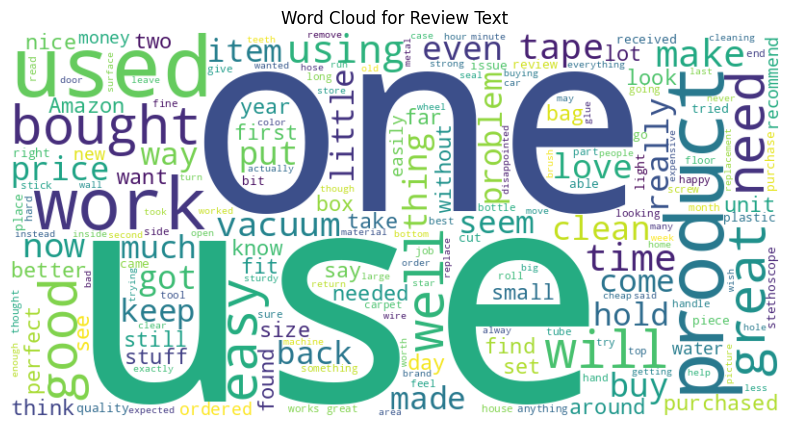

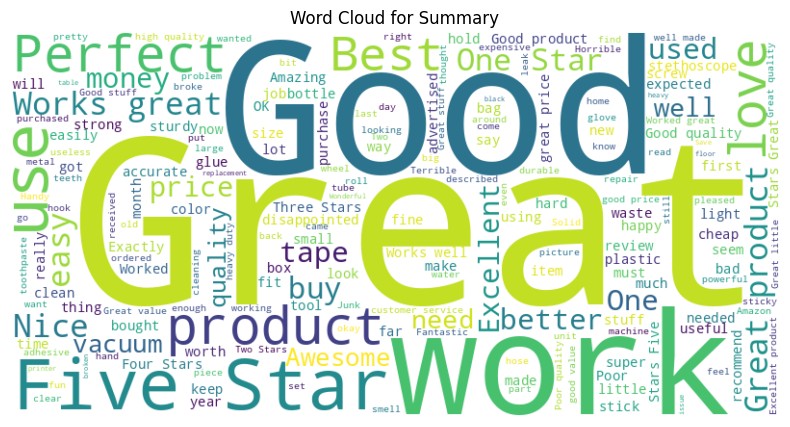

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(review_text_str, "Word Cloud for Review Text")
generate_word_cloud(summary_str, "Word Cloud for Summary")


# Modelling

## Data Splitting

In [ ]:

from pyspark.ml.feature import StringIndexer

# Indexing is required to convert string identifiers to numeric indices for the ALS algorithm
indexer_user = StringIndexer(inputCol="reviewerID", outputCol="userIndex")
df = indexer_user.fit(df).transform(df)

indexer_item = StringIndexer(inputCol="asin", outputCol="itemIndex")
df = indexer_item.fit(df).transform(df)

(train, test) = df.randomSplit([0.8, 0.2])


## ALS

refer: https://www.kaggle.com/code/nadianizam/h-m-fashion-recommendation-with-pyspark



In [30]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Setting up the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userIndex", itemCol="itemIndex", ratingCol="overall", coldStartStrategy="drop")

# Fitting the ALS model on the training data
model = als.fit(train)

# Predicting on the train and test sets
predictions_train = model.transform(train)
predictions_test = model.transform(test)

# Create an RMSE evaluator using the label and predicted columns
reg_evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")

# Evaluate the model on training data
rmse_train = reg_evaluator.evaluate(predictions_train)

# Evaluate the model on test data
rmse_test = reg_evaluator.evaluate(predictions_test)


In [31]:
rmse_train

0.015453865517166649

In [32]:
rmse_test

3.1134746854046376

## GraphFrame

In [34]:
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.6 MB/s eta 0:00:00


In [35]:
from graphframes import GraphFrame

# Assuming 'df' is your original PySpark DataFrame and it has been indexed
# Create vertices DataFrame
vertices = df.selectExpr("userIndex as id").distinct().union(df.selectExpr("itemIndex as id").distinct()) # check if those two index overlap

# Create edges DataFrame
edges = df.selectExpr("userIndex as src", "itemIndex as dst", "overall as rating")

# Create a GraphFrame
graph = GraphFrame(vertices, edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Py4JJavaError: ignored

In [36]:
# TO DO
# 1: Hyperparameter tuning
# 2: How to make use of the graph functions?